# PPOの学習を行う
- Criticネットワークは棋譜データで事前学習済み

In [1]:
import os
import math
import time
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import torchinfo
from tqdm.notebook import tqdm

import sys
# 親ディレクトリをパスに追加して相対インポートできるようにする
sys.path.append("../")

from utils.mori.othello_env import OthelloEnv
from utils.mori.othello_reward import OthelloReward

## アーキテクチャ定義

In [2]:
class ResBlock(nn.Module):
    def __init__(self, ch: int, bn_eps: float = 1e-5, zero_init: bool = True):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(ch, eps=bn_eps)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(ch, eps=bn_eps)
        if zero_init:
            # 出力を初期は恒等写像に近づけて安定化
            nn.init.zeros_(self.bn2.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(x + h)

class CriticNet(nn.Module):
    def __init__(
        self,
        in_ch: int = 2,
        width: int = 32,
        num_res_blocks: int = 3,
        bn_eps: float = 1e-5,
        head_hidden_size: int = 32,
        use_gap: bool = True,
        norm_head: str = "ln",
    ):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, width, 3, padding=1, bias=False),
            nn.GroupNorm(1, width, eps=bn_eps),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.Sequential(
            *[ResBlock(width, bn_eps=bn_eps, zero_init=True) for _ in range(num_res_blocks)]
        )

        # value head: 1x1 conv → (norm) → ReLU
        self.value_conv = nn.Conv2d(width, 1, kernel_size=1, bias=False)

        if norm_head == "bn":
            self.value_norm = nn.GroupNorm(1, 1, eps=bn_eps)
        elif norm_head == "ln":
            # LayerNorm over (C,H,W) = (1,8,8) -> normalized_shape=(1,8,8)
            self.value_norm = nn.LayerNorm((1, 8, 8))
        elif norm_head == "gn":
            self.value_norm = nn.GroupNorm(1, 1)  # 1 group = LayerNorm的
        else:
            self.value_norm = nn.Identity()

        self.use_gap = use_gap
        if use_gap:
            in_fc = 1  # GAPで(1,)に
        else:
            in_fc = 8 * 8

        self.value_fc1 = nn.Linear(in_fc, head_hidden_size)
        self.value_fc2 = nn.Linear(head_hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.stem(x)
        h = self.res_blocks(h)

        h = self.value_conv(h)  # (B,1,8,8)
        if isinstance(self.value_norm, nn.LayerNorm):
            h = self.value_norm(h)  # 形状そのまま
        else:
            h = self.value_norm(h)
        h = F.relu(h)

        if self.use_gap:
            h = h.mean(dim=(2, 3), keepdim=False)  # (B,1)
        else:
            h = h.view(h.size(0), -1)             # (B,64)

        h = F.relu(self.value_fc1(h))
        v = torch.tanh(self.value_fc2(h))         # [-1, 1]
        return v  # (B,1)

In [3]:
dummy_input = torch.randn(4, 2, 8, 8)
torchinfo.summary(CriticNet(), input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
CriticNet                                [4, 1]                    --
├─Sequential: 1-1                        [4, 32, 8, 8]             --
│    └─Conv2d: 2-1                       [4, 32, 8, 8]             576
│    └─GroupNorm: 2-2                    [4, 32, 8, 8]             64
│    └─ReLU: 2-3                         [4, 32, 8, 8]             --
├─Sequential: 1-2                        [4, 32, 8, 8]             --
│    └─ResBlock: 2-4                     [4, 32, 8, 8]             --
│    │    └─Conv2d: 3-1                  [4, 32, 8, 8]             9,216
│    │    └─BatchNorm2d: 3-2             [4, 32, 8, 8]             64
│    │    └─Conv2d: 3-3                  [4, 32, 8, 8]             9,216
│    │    └─BatchNorm2d: 3-4             [4, 32, 8, 8]             64
│    └─ResBlock: 2-5                     [4, 32, 8, 8]             --
│    │    └─Conv2d: 3-5                  [4, 32, 8, 8]             9,216
│    

In [4]:
class ActorNet(nn.Module):
    def __init__(
        self,
        in_ch: int = 2,
        width: int = 32,
        num_res_blocks: int = 3,
        bn_eps: float = 1e-5,
    ):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, width, 3, padding=1, bias=False),
            nn.GroupNorm(1, width, eps=bn_eps),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.Sequential(
            *[ResBlock(width, bn_eps=bn_eps, zero_init=False) for _ in range(num_res_blocks)]
        )
        # 65アクション（0..63: 盤上, 64: パス）
        self.policy_head = nn.Sequential(
            nn.Conv2d(in_channels=width, out_channels=2, kernel_size=1, bias=False),  # (B,2,8,8)
            nn.ReLU(inplace=True),
        )
        self.logits_fc = nn.Linear(2 * 8 * 8, 65)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.stem(x)
        h = self.res_blocks(h)
        h = self.policy_head(h)
        h = h.view(h.size(0), -1)
        logits = self.logits_fc(h)  # (B,65)
        return logits

In [5]:
dummy_input = torch.randn(4, 2, 8, 8)
torchinfo.summary(ActorNet(), input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
ActorNet                                 [4, 65]                   --
├─Sequential: 1-1                        [4, 32, 8, 8]             --
│    └─Conv2d: 2-1                       [4, 32, 8, 8]             576
│    └─GroupNorm: 2-2                    [4, 32, 8, 8]             64
│    └─ReLU: 2-3                         [4, 32, 8, 8]             --
├─Sequential: 1-2                        [4, 32, 8, 8]             --
│    └─ResBlock: 2-4                     [4, 32, 8, 8]             --
│    │    └─Conv2d: 3-1                  [4, 32, 8, 8]             9,216
│    │    └─BatchNorm2d: 3-2             [4, 32, 8, 8]             64
│    │    └─Conv2d: 3-3                  [4, 32, 8, 8]             9,216
│    │    └─BatchNorm2d: 3-4             [4, 32, 8, 8]             64
│    └─ResBlock: 2-5                     [4, 32, 8, 8]             --
│    │    └─Conv2d: 3-5                  [4, 32, 8, 8]             9,216
│    

# エージェント定義

In [6]:
@dataclass
class PPOConfig:
    total_updates: int = 2000
    rollout_length: int = 256
    minibatch_size: int = 1024
    ppo_epochs: int = 4
    gamma: float = 0.99
    gae_lambda: float = 0.95
    clip_coef: float = 0.2
    ent_coef: float = 0.01
    vf_coef: float = 0.5
    max_grad_norm: float = 0.5
    lr: float = 3e-4
    device: torch.device = (
        torch.device("mps") if torch.backends.mps.is_available()
        else torch.device("cuda") if torch.cuda.is_available()
        else torch.device("cpu")
    )
    seed: int = 42
    save_dir: str = "model_weights/ppo"
    pretrained_critic_path: Optional[str] = "/Users/mori/dev/othello-with-rl/rl_agent/mori/models/pretrained_criticnet.pt"
    reward_eta: float = 0.1
    reward_clip: Optional[float] = 0.5

class PPOAgent:
    def __init__(self, actor: ActorNet, critic: CriticNet, cfg: PPOConfig):
        self.actor = actor.to(cfg.device)
        self.critic = critic.to(cfg.device)
        # 事前学習Criticは固定
        for p in self.critic.parameters():
            p.requires_grad = False
        self.optimizer = torch.optim.Adam(self.actor.parameters(), lr=cfg.lr)
        self.cfg = cfg

    @torch.no_grad()
    def get_value(self, obs: torch.Tensor) -> torch.Tensor:
        """
        Criticネットワークの出力を返す(方策で選択した行動の価値を返す)

        Args:
            obs (torch.Tensor): 状態

        Returns:
            torch.Tensor: 価値
        """
        return self.critic(obs).squeeze(-1)

    def get_action_and_logp(
        self,
        obs: torch.Tensor,
        legal_mask: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        方策ネットワークの出力を返す(方策で選択した行動の価値を返す)

        Args:
            obs (torch.Tensor): 状態
            legal_mask (torch.Tensor): 合法手のマスク

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: 行動、行動の確率、行動の対数確率
        """
        logits = self.actor(obs)  # (B,65)
        # 合法手のマスクを適用
        legal_logits = logits + legal_mask
        dist = Categorical(logits=legal_logits)
        action = dist.sample()
        logp = dist.log_prob(action)
        return action, dist.probs, logp

    def evaluate_actions(
        self,
        obs: torch.Tensor,
        actions: torch.Tensor,
        legal_mask: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        行動の価値とエントロピーを返す

        Args:
            obs (torch.Tensor): 状態
            actions (torch.Tensor): 行動
            legal_mask (torch.Tensor): 合法手のマスク

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: 行動の価値、エントロピー
        """
        logits = self.actor(obs)
        masked_logits = logits + legal_mask
        dist = Categorical(logits=masked_logits)
        logp = dist.log_prob(actions)
        entropy = dist.entropy()
        return logp, entropy

In [7]:
def build_legal_mask(
    legal_actions: List[int],
    device: torch.device,
) -> torch.Tensor:
    """
    合法手のマスクを返す
    """
    # 65次元、合法手=0、違法手=-inf の加算マスク
    mask = torch.full((65,), fill_value=-1e9, device=device)
    if len(legal_actions) == 0:
        mask[64] = 0.0  # パスのみ許可
    else:
        mask[legal_actions] = 0.0
    return mask


def compute_gae(
    rewards: torch.Tensor,
    values: torch.Tensor,
    dones: torch.Tensor,
    cfg: PPOConfig,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    GAEを計算する

    Args:
        rewards (torch.Tensor): 報酬
        values (torch.Tensor): 値
        dones (torch.Tensor): 終端フラグ
        cfg (PPOConfig): PPOの設定

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: 優先順位、報酬
    """
    T = values.size(0) - 1  # values は T+1
    adv = torch.zeros(T, device=values.device)
    lastgaelam = 0.0
    for t in reversed(range(T)):
        nextnonterminal = 1.0 - dones[t]  # dones は長さ T
        delta = rewards[t] + cfg.gamma * values[t + 1] * nextnonterminal - values[t]
        lastgaelam = delta + cfg.gamma * cfg.gae_lambda * nextnonterminal * lastgaelam
        adv[t] = lastgaelam
    returns = adv + values[:-1]  # どちらも長さ T
    return adv, returns

def collect_batch_with_min_terminals(env, agent, cfg, reward_fn, min_terminals=1, max_retries=3):
    # まず1回収集
    batch = rollout(env, agent, cfg, reward_fn)
    term_count = int((batch["dones"] == 1).sum().item()) if "dones" in batch else 0

    retries = 0
    while term_count < min_terminals and retries < max_retries:
        extra = rollout(env, agent, cfg, reward_fn)
        # 連結（簡略のためCPU側に一度集めて cat）
        batch = {
            k: torch.cat([batch[k], extra[k]], dim=0) if k not in ["returns","advantages"] else batch[k]
            for k in batch.keys()
        }
        # 連結後に advantages/returns は再計算するのがベストだが、簡易には追加分だけ学習に使っても良い
        # ここでは終局確保のためのサンプル増やしが主目的
        term_count += int((extra["dones"] == 1).sum().item())
        retries += 1

    return batch

def rollout(env: OthelloEnv, agent: PPOAgent, cfg: PPOConfig, reward_fn: Optional[OthelloReward]) -> Dict[str, torch.Tensor]:
    device = cfg.device
    T = cfg.rollout_length

    obs_buf = torch.empty((T, 2, 8, 8), device=device)
    act_buf = torch.empty((T,), dtype=torch.long, device=device)
    logp_buf = torch.empty((T,), dtype=torch.float32, device=device)
    rew_buf = torch.zeros((T,), dtype=torch.float32, device=device)
    done_buf = torch.empty((T,), dtype=torch.float32, device=device)
    mask_buf = torch.empty((T, 65), dtype=torch.float32, device=device)
    val_buf = torch.empty((T,), dtype=torch.float32, device=device)

    obs_np = env.reset()
    with torch.inference_mode():
        for t in range(T):
            obs_t = torch.from_numpy(obs_np).to(device)
            obs_buf[t].copy_(obs_t)

            legal_acts = env.legal_actions()
            mask = build_legal_mask(legal_acts, device)
            mask_buf[t].copy_(mask)

            v = agent.get_value(obs_t.unsqueeze(0))
            action, _, logp = agent.get_action_and_logp(obs_t.unsqueeze(0), mask.unsqueeze(0))

            # 環境に reward_fn を渡し、環境が返す報酬をそのまま採用
            next_obs_np, r_env, done, _ = env.step(int(action.item()), reward_fn=reward_fn)

            act_buf[t] = action
            logp_buf[t] = logp
            rew_buf[t] = float(r_env)        # ← 重要: 反則終了(-10)も含め非ゼロが入る
            done_buf[t] = float(done)
            val_buf[t] = v

            obs_np = env.reset() if done else next_obs_np

        last_obs_t = torch.from_numpy(obs_np).to(device)
        last_v = agent.get_value(last_obs_t.unsqueeze(0)).squeeze(0)

    values = torch.cat([val_buf, last_v.unsqueeze(0)], dim=0)

    advantages, returns = compute_gae(
        rewards=rew_buf,
        values=values,
        dones=done_buf,
        cfg=cfg,
    )
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return {
        "obs": obs_buf,
        "actions": act_buf,
        "logprobs": logp_buf,
        "advantages": advantages,
        "returns": returns,
        "masks": mask_buf,
        "rewards": rew_buf,  # ← 追加
        "dones": done_buf,   # ← 追加（任意）
    }

In [8]:
def ppo_update(
    agent: PPOAgent,
    batch: Dict[str, torch.Tensor],
    cfg: PPOConfig,
) -> Dict[str, float]:
    """
    PPOの更新を行う

    Args:
        agent (PPOAgent): PPOエージェント
        batch (Dict[str, torch.Tensor]): バッチ
        cfg (PPOConfig): PPOの設定

    Returns:
        Dict[str, float]: 更新結果
    """
    obs = batch["obs"]
    actions = batch["actions"]
    old_logprobs = batch["logprobs"]
    advantages = batch["advantages"]
    returns = batch["returns"]
    masks = batch["masks"]

    B = obs.size(0)
    idx = torch.randperm(B, device=cfg.device)

    sum_policy_loss = 0.0
    sum_entropy = 0.0
    sum_approx_kl = 0.0
    num_updates = 0

    for _ in range(cfg.ppo_epochs):
        for start in range(0, B, cfg.minibatch_size):
            end = min(start + cfg.minibatch_size, B)
            mb_idx = idx[start:end]

            mb_obs = obs[mb_idx]
            mb_actions = actions[mb_idx]
            mb_old_logp = old_logprobs[mb_idx]
            mb_adv = advantages[mb_idx]
            mb_returns = returns[mb_idx]
            mb_masks = masks[mb_idx]

            new_logp, entropy = agent.evaluate_actions(mb_obs, mb_actions, mb_masks)
            ratio = (new_logp - mb_old_logp).exp()
            surr1 = ratio * mb_adv
            surr2 = torch.clamp(ratio, 1.0 - cfg.clip_coef, 1.0 + cfg.clip_coef) * mb_adv
            policy_loss = -torch.min(surr1, surr2).mean()

            # 近似KL (平均)
            approx_kl = (mb_old_logp - new_logp).mean()

            loss = policy_loss - cfg.ent_coef * entropy.mean()

            agent.optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(agent.actor.parameters(), cfg.max_grad_norm)
            agent.optimizer.step()

            # メトリクス集計
            sum_policy_loss += float(policy_loss.item())
            sum_entropy += float(entropy.mean().item())
            sum_approx_kl += float(approx_kl.item())
            num_updates += 1

    # 平均を返す
    if num_updates > 0:
        return {
            "policy_loss": sum_policy_loss / num_updates,
            "entropy": sum_entropy / num_updates,
            "approx_kl": sum_approx_kl / num_updates,
        }
    else:
        return {"policy_loss": 0.0, "entropy": 0.0, "approx_kl": 0.0}

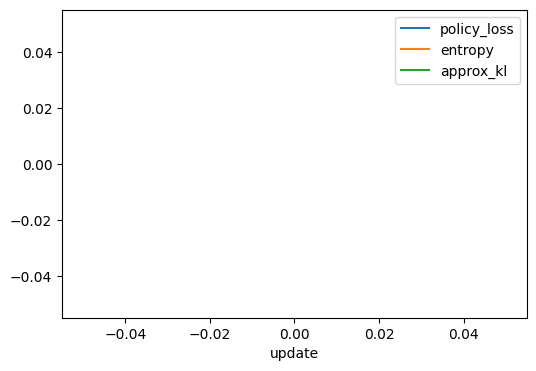

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# 履歴を保持するバッファ
hist_update = []
hist_pl = []
hist_ent = []
hist_kl = []

# 図の準備（再利用）
fig, ax = plt.subplots(figsize=(6, 4))
lines = {
    "policy_loss": ax.plot([], [], label="policy_loss")[0],
    "entropy": ax.plot([], [], label="entropy")[0],
    "approx_kl": ax.plot([], [], label="approx_kl")[0],
}
ax.set_xlabel("update")
ax.legend()

In [10]:
def load_pretrained_critic(cfg: PPOConfig) -> CriticNet:
    """
    事前学習済みのCriticネットワークを読み込む

    Args:
        cfg (PPOConfig): PPOの設定

    Returns:
        CriticNet: 事前学習済みのCriticネットワーク
    """
    critic = CriticNet()
    if cfg.pretrained_critic_path and os.path.exists(cfg.pretrained_critic_path):
        state = torch.load(cfg.pretrained_critic_path, map_location="cpu")
        # state_dict かモデル一式かを判定
        if isinstance(state, dict) and all(isinstance(k, str) for k in state.keys()):
            critic.load_state_dict(state)
        else:
            # torch.save(model) 形式を想定
            try:
                critic = state
            except Exception:
                raise RuntimeError("Unsupported critic checkpoint format")
    else:
        raise FileNotFoundError(f"Pretrained critic not found: {cfg.pretrained_critic_path}")
    return critic

def ensure_dir(path: str):
    """
    ディレクトリを作成する

    Args:
        path (str): 作成するディレクトリのパス
    """
    os.makedirs(path, exist_ok=True)

def train(cfg: PPOConfig) -> None:
    """
    PPOの学習を行う

    Args:
        cfg (PPOConfig): PPOの設定
    """
    import os
    import time
    import numpy as np
    import matplotlib.pyplot as plt
    from IPython.display import clear_output, display

    torch.manual_seed(cfg.seed)
    np.random.seed(cfg.seed)

    # 保存ディレクトリ作成
    ensure_dir(cfg.save_dir)

    # 環境と報酬
    env = OthelloEnv()
    reward_fn = OthelloReward()

    # モデル構築
    actor = ActorNet()
    critic = load_pretrained_critic(cfg)
    agent = PPOAgent(actor, critic, cfg)

    # 可視化の準備（2段プロット：上=学習メトリクス, 下=終局報酬）
    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

    lines = {
        "policy_loss": ax.plot([], [], label="policy_loss")[0],
        "entropy": ax.plot([], [], label="entropy")[0],
        "approx_kl": ax.plot([], [], label="approx_kl")[0],
    }
    ax.set_title("Training Metrics (PPO)")
    ax.set_ylabel("loss / entropy / kl")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")

    # 下段：終局報酬（折れ線＋終局点を散布）
    lines2 = {
        "terminal_reward": ax2.plot([], [], label="terminal_reward (avg per update)",
                                    color="tab:purple")[0],
    }
    ax2.set_xlabel("update")
    ax2.set_ylabel("terminal_reward")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="best")

    # 履歴
    hist_update = []
    hist_pl = []
    hist_ent = []
    hist_kl = []
    hist_term_rew = []

    # 直近の終局報酬（終局が無いupdateでも線が完全に消えないよう保持）
    last_term_rew = float("nan")

    # ログ
    plot_every = 10    # 10アップデートごとに描画
    max_points = 1000  # メモリ抑制のための履歴上限（任意）
    start_time = time.time()

    for update in range(1, cfg.total_updates + 1):
        # 1回のupdateで最低1回の終局を確保
        batch = collect_batch_with_min_terminals(env, agent, cfg, reward_fn, min_terminals=1, max_retries=3)
        metrics = ppo_update(agent, batch, cfg)

        # 終局報酬の抽出（非ゼロのみ）
        avg_term_rew = float("nan")
        if isinstance(batch, dict) and ("rewards" in batch):
            term_rews = batch["rewards"][batch["rewards"] != 0]
            if term_rews.numel() > 0:
                # 1 update で複数終局があれば平均で代表
                avg_term_rew = float(term_rews.mean().item())
                last_term_rew = avg_term_rew
                # 終局点を散布図で可視化（見逃しを防ぐ）
                xs = [update] * term_rews.numel()
                ys = term_rews.detach().cpu().tolist()
                ax2.scatter(xs, ys, s=12, color="tab:purple", alpha=0.7)
            else:
                # 今回終局が無ければ直近値をキャリー（線が完全に消えないように）
                avg_term_rew = last_term_rew
        else:
            # rolloutがまだrewardsを返していない場合に備えたフォールバック
            avg_term_rew = last_term_rew

        # 履歴に追加
        hist_update.append(update)
        hist_pl.append(float(metrics.get("policy_loss", 0.0)))
        hist_ent.append(float(metrics.get("entropy", 0.0)))
        hist_kl.append(float(metrics.get("approx_kl", 0.0)))
        hist_term_rew.append(avg_term_rew)

        # 古いデータの間引き
        if len(hist_update) > max_points:
            hist_update = hist_update[-max_points:]
            hist_pl = hist_pl[-max_points:]
            hist_ent = hist_ent[-max_points:]
            hist_kl = hist_kl[-max_points:]
            hist_term_rew = hist_term_rew[-max_points:]

        # 指定間隔で描画更新（clear_output → display(fig) は一度だけ）
        if update % plot_every == 0:
            clear_output(wait=True)

            # 上段（学習メトリクス）
            lines["policy_loss"].set_data(hist_update, hist_pl)
            lines["entropy"].set_data(hist_update, hist_ent)
            lines["approx_kl"].set_data(hist_update, hist_kl)
            ax.relim()
            ax.autoscale_view()
            ax.set_title(
                f"Training Metrics (PPO)  |  elapsed={(time.time()-start_time)/60:.2f}m"
            )

            # 下段（終局報酬の平均）
            lines2["terminal_reward"].set_data(hist_update, hist_term_rew)
            ax2.relim()
            ax2.autoscale_view()

            display(fig)
            plt.pause(0.01)

        # チェックポイント保存
        if update % 100 == 0:
            ckpt = os.path.join(cfg.save_dir, f"actor_update_{update}.pth")
            torch.save(agent.actor.state_dict(), ckpt)

    # 最終セーブ
    final_ckpt = os.path.join(cfg.save_dir, "actor_final.pth")
    torch.save(agent.actor.state_dict(), final_ckpt)
    print(f"Saved final actor to {final_ckpt}")

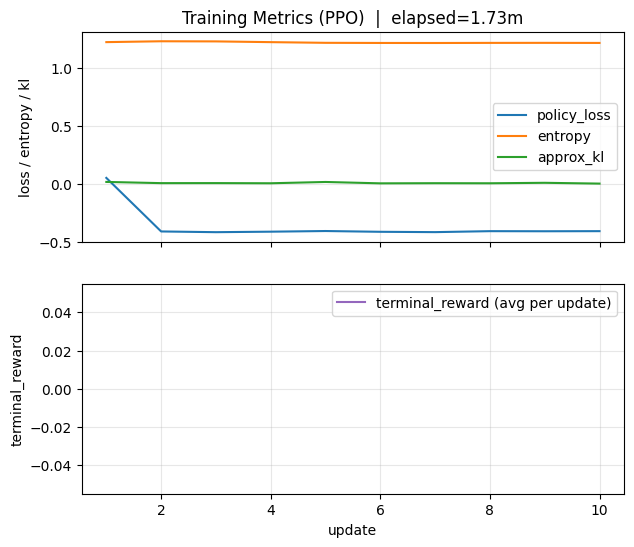

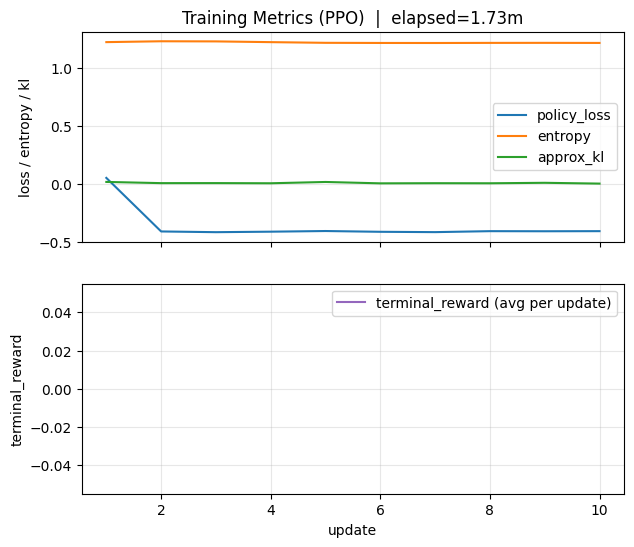

KeyboardInterrupt: 

In [11]:
# 学習実行
train(PPOConfig())